In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.backend_bases
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 
from sklearn.compose import make_column_selector

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag # for bagging
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance

#eda
import pandas_profiling

# Misc
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


## Explore data: all year NONA

In [31]:
df_nona = pd.read_csv("df_nona.csv")

In [32]:
df_nona.dtypes

year                 float64
name                  object
state                 object
total_mwh            float64
total_cust           float64
no                   float64
type                  object
saidi_nomed          float64
saifi_nomed           object
caidi_nomed           object
circuits             float64
voltage              float64
nerc                  object
gen_mwh               object
purchase_mwh         float64
ba                    object
pv_mwh               float64
wind_mwh             float64
nm_mwh               float64
ee_mwh               float64
dem_res_customers    float64
dem_res_mwh           object
nm_pct               float64
pv_pct               float64
wind_pct             float64
ee_pct               float64
dem_res_cust_pct     float64
dtype: object

In [33]:
# convert object variables to categories
for col in df_nona.select_dtypes(include="object"):
    df_nona[col] = df_nona[col].astype('category')

## Outcomes I wanna use: 
- Control: Type, State, NERC, total MWH, Voltage
- NM pct, EE pct, Dem res customer pct

In [34]:
y = df_nona['saidi_nomed']
X = df_nona[['state','type','total_mwh',
           'nerc','circuits','voltage','nm_pct','ee_pct',
           'dem_res_cust_pct']]

In [35]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [36]:
print(train_X.shape[0]/df_nona.shape[0])
print(test_X.shape[0]/df_nona.shape[0])

0.7495854063018242
0.2504145936981758


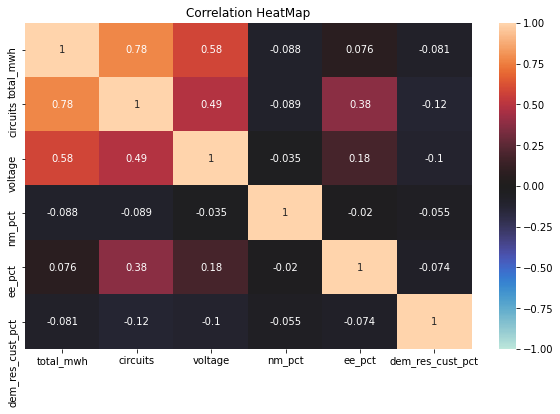

In [37]:
#creating pairwise correlation of columns using Pearson's R,
corr = train_X.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot=True, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

### Remove either circuits or total mwh

In [10]:
df_nona.skew().sort_values(ascending = False)

wind_mwh             17.249275
pv_mwh                7.313748
nm_mwh                7.246931
pv_pct                6.732136
nm_pct                6.620598
wind_pct              6.053658
dem_res_customers     4.778017
ee_mwh                4.714544
purchase_mwh          4.390138
voltage               3.947013
ee_pct                3.682007
total_cust            3.402749
total_mwh             3.265339
saidi_nomed           3.017277
circuits              2.814541
dem_res_cust_pct      1.850658
no                    1.384839
year                 -0.066280
dtype: float64

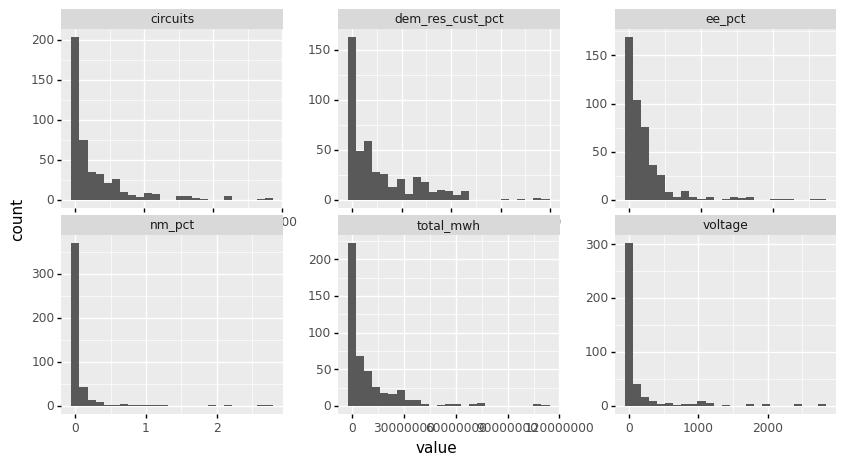

<ggplot: (8778789821529)>

In [11]:
# Plot the continuous variables 
df_num = train_X.select_dtypes(include="number").melt()

(
    ggplot(df_num,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

In [66]:
df_nona_log = df_nona.copy()

# lgo some variables
df_nona_log['total_mwh'] = np.log(df_nona_log['total_mwh'])
df_nona_log['circuits'] = np.log(df_nona_log['circuits'])
# df_nona_log['voltage'] = np.log(df_nona_log['voltage'] + 1)
#df_nona_log['nm_pct'] = np.log(df_nona_log['nm_pct'] + 1)
df_nona_log['ee_pct'] = np.log(df_nona_log['ee_pct'] + 1)
#df_nona_log['dem_res_pct'] = np.log(df_nona_log['dem_res_pct'] + 1)

# voltage, net metered, and remand response percent 
median_voltage_pct = df_nona.loc[df_nona_log['voltage'] > 0,'voltage'].median()
df_nona_log['voltage'] =  np.where(df_nona_log['voltage']==0,0,np.where(df_nona_log['voltage'] <= median_voltage_pct,1,2))

# demand response pct
median_dr_pct = df_nona.loc[df_nona_log['dem_res_cust_pct'] > 0,'dem_res_cust_pct'].median()
df_nona_log['dem_res_cust_pct'] =  np.where(df_nona_log['dem_res_cust_pct']==0,0,np.where(df_nona_log['dem_res_cust_pct'] <= median_dr_pct,1,2))

# nm percent 
median_nm_pct = df_nona.loc[df_nona_log['nm_pct'] > 0,'nm_pct'].median()
df_nona_log['nm_pct'] =  np.where(df_nona_log['nm_pct']==0,0,np.where(df_nona_log['nm_pct'] <= median_nm_pct,1,2))

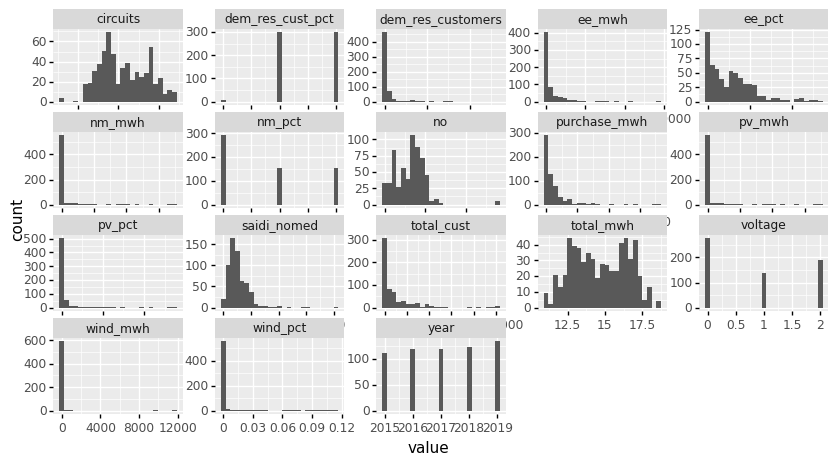

<ggplot: (8778771206813)>

In [39]:
# Plot the continuous variables 
df_nona_num = df_nona_log.select_dtypes(include="number").melt()

(
    ggplot(df_nona_anum,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

### Let's dummify NERC regions, state, and utility type

In [67]:
nerc_dummies = pd.get_dummies(df_nona_log.nerc)

In [68]:
# we'll use FRCC as our reference category
nerc_dummies = nerc_dummies.drop(['FRCC'],axis=1)
nerc_dummies.head()

,HI,MRO,NPCC,RFC,SERC,SPP,TRE,WECC
0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0


In [69]:
df_nona_log = pd.concat([df_nona_log.drop(['nerc'],axis=1),nerc_dummies],axis=1)

In [70]:
type_dummies = pd.get_dummies(df_nona_log.type)

In [71]:
# we'll use State as our reference category
type_dummies = type_dummies.drop(['State'],axis=1)
type_dummies.head()

,Cooperative,Investor Owned,Municipal,Political Subdivision
0,1,0,0,0
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


In [72]:
df_nona_log = pd.concat([df_nona_log.drop(['type'],axis=1),type_dummies],axis=1)

In [73]:
state_dummies = pd.get_dummies(df_nona_log.state)

In [74]:
state_dummies

,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,...,NV,NY,OH,OK,PA,SC,SD,TX,VA,WI
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# we'll use AR as our reference category
state_dummies = state_dummies.drop(['AR'],axis=1)
state_dummies.head()

,AL,AZ,CA,CO,CT,DE,FL,GA,HI,IA,...,NV,NY,OH,OK,PA,SC,SD,TX,VA,WI
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
df_nona_log = pd.concat([df_nona_log.drop(['state'],axis=1),state_dummies],axis=1)

In [77]:
df_nona_log.columns

Index(['year', 'name', 'total_mwh', 'total_cust', 'no', 'saidi_nomed',
       'saifi_nomed', 'caidi_nomed', 'circuits', 'voltage', 'gen_mwh',
       'purchase_mwh', 'ba', 'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
       'dem_res_customers', 'dem_res_mwh', 'nm_pct', 'pv_pct', 'wind_pct',
       'ee_pct', 'dem_res_cust_pct', 'HI', 'MRO', 'NPCC', 'RFC', 'SERC', 'SPP',
       'TRE', 'WECC', 'Cooperative', 'Investor Owned', 'Municipal',
       'Political Subdivision', 'AL', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'PA', 'SC', 'SD', 'TX', 'VA', 'WI'],
      dtype='object')

## Outcomes I'm using
- Control: Type, State, NERC, total MWH, Voltage
- NM pct, EE pct, Dem res customer pct

In [78]:
y = df_nona_log['saidi_nomed']
X = df_nona_log.drop(columns=['year', 'name', 'total_cust', 'no', 'saidi_nomed',
       'saifi_nomed', 'caidi_nomed', 'circuits', 'gen_mwh',
       'purchase_mwh', 'ba', 'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
       'dem_res_customers', 'dem_res_mwh', 'pv_pct', 'wind_pct'])

In [79]:
train_X_log, test_X_log, train_y_log, test_y_log = train_test_split(X,y,test_size=.25,random_state=1997)

In [80]:
train_X_log.columns

Index(['total_mwh', 'voltage', 'nm_pct', 'ee_pct', 'dem_res_cust_pct', 'HI',
       'MRO', 'NPCC', 'RFC', 'SERC', 'SPP', 'TRE', 'WECC', 'Cooperative',
       'Investor Owned', 'Municipal', 'Political Subdivision', 'AL', 'AZ',
       'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'PA', 'SC', 'SD', 'TX', 'VA',
       'WI'],
      dtype='object')

## Make model comparison

In [82]:
# EVERYTHING must hold constant other than the algorithm because we're looking for the best algorithm 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111) # make sure splits are same with random state

In [83]:
type(fold_generator)

sklearn.model_selection._split.KFold

In [84]:
# just MSE but negative, used by sklearn
use_metrics = ["neg_mean_squared_error"] 

### Linear Model

In [85]:
lm_scores = cross_validate(LM(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

In [86]:
mod = LM()

In [87]:
mod.fit(train_X_log, train_y_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
mod.coef_

array([ 1.64207874e+00,  1.69570942e+00,  6.00365345e-01, -1.21644393e+01,
       -1.37938768e+01, -4.51534375e+13,  4.86197440e+02, -1.80464139e+15,
        5.41217097e+02,  4.50998721e+02,  4.80119397e+02,  3.03675113e+02,
        2.71020140e+02,  8.48202062e+01,  6.84972307e+01,  2.58854558e+01,
        6.15031566e+01, -6.42664491e+01,  8.66500211e+01,  1.31618360e+02,
        1.06070830e+02,  1.80464139e+15, -1.57452407e+02,  3.98857577e+02,
       -8.38069251e+01,  4.51534375e+13, -1.01594845e+02,  1.90729996e+02,
       -1.27972587e+02, -9.93673011e+01, -3.84995065e+01, -4.74834439e+01,
        3.09017546e+01,  1.80464139e+15, -1.29460938e+02, -5.34375000e+01,
       -8.83750000e+01, -6.84101562e+01, -7.79062500e+01,  1.89187500e+02,
       -3.25000000e+00, -1.36750000e+02, -9.92500000e+01,  1.80464139e+15,
       -1.82250000e+02,  1.31312500e+02,  1.28718750e+02,  1.80464139e+15,
       -1.11250000e+02,  5.00000000e+00, -1.24171875e+02, -7.75625000e+01,
       -1.20500000e+02,  

### KNN

In [89]:
knn_scores = cross_validate(KNN(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

In [90]:
KNN().get_params

<bound method BaseEstimator.get_params of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')>

### Decision Tree

In [91]:
dt_scores = cross_validate(DTree(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

#### Side Note: Plotting a Decision Tree
First, a quick side note on the decision trees. When we built a tree from scratch, we discussed looking at the **decision rules** of the tree. There is a very straight forward way of doing this in `sklearn`.

In [92]:
# grab the column names
col_names = train_X_log.columns

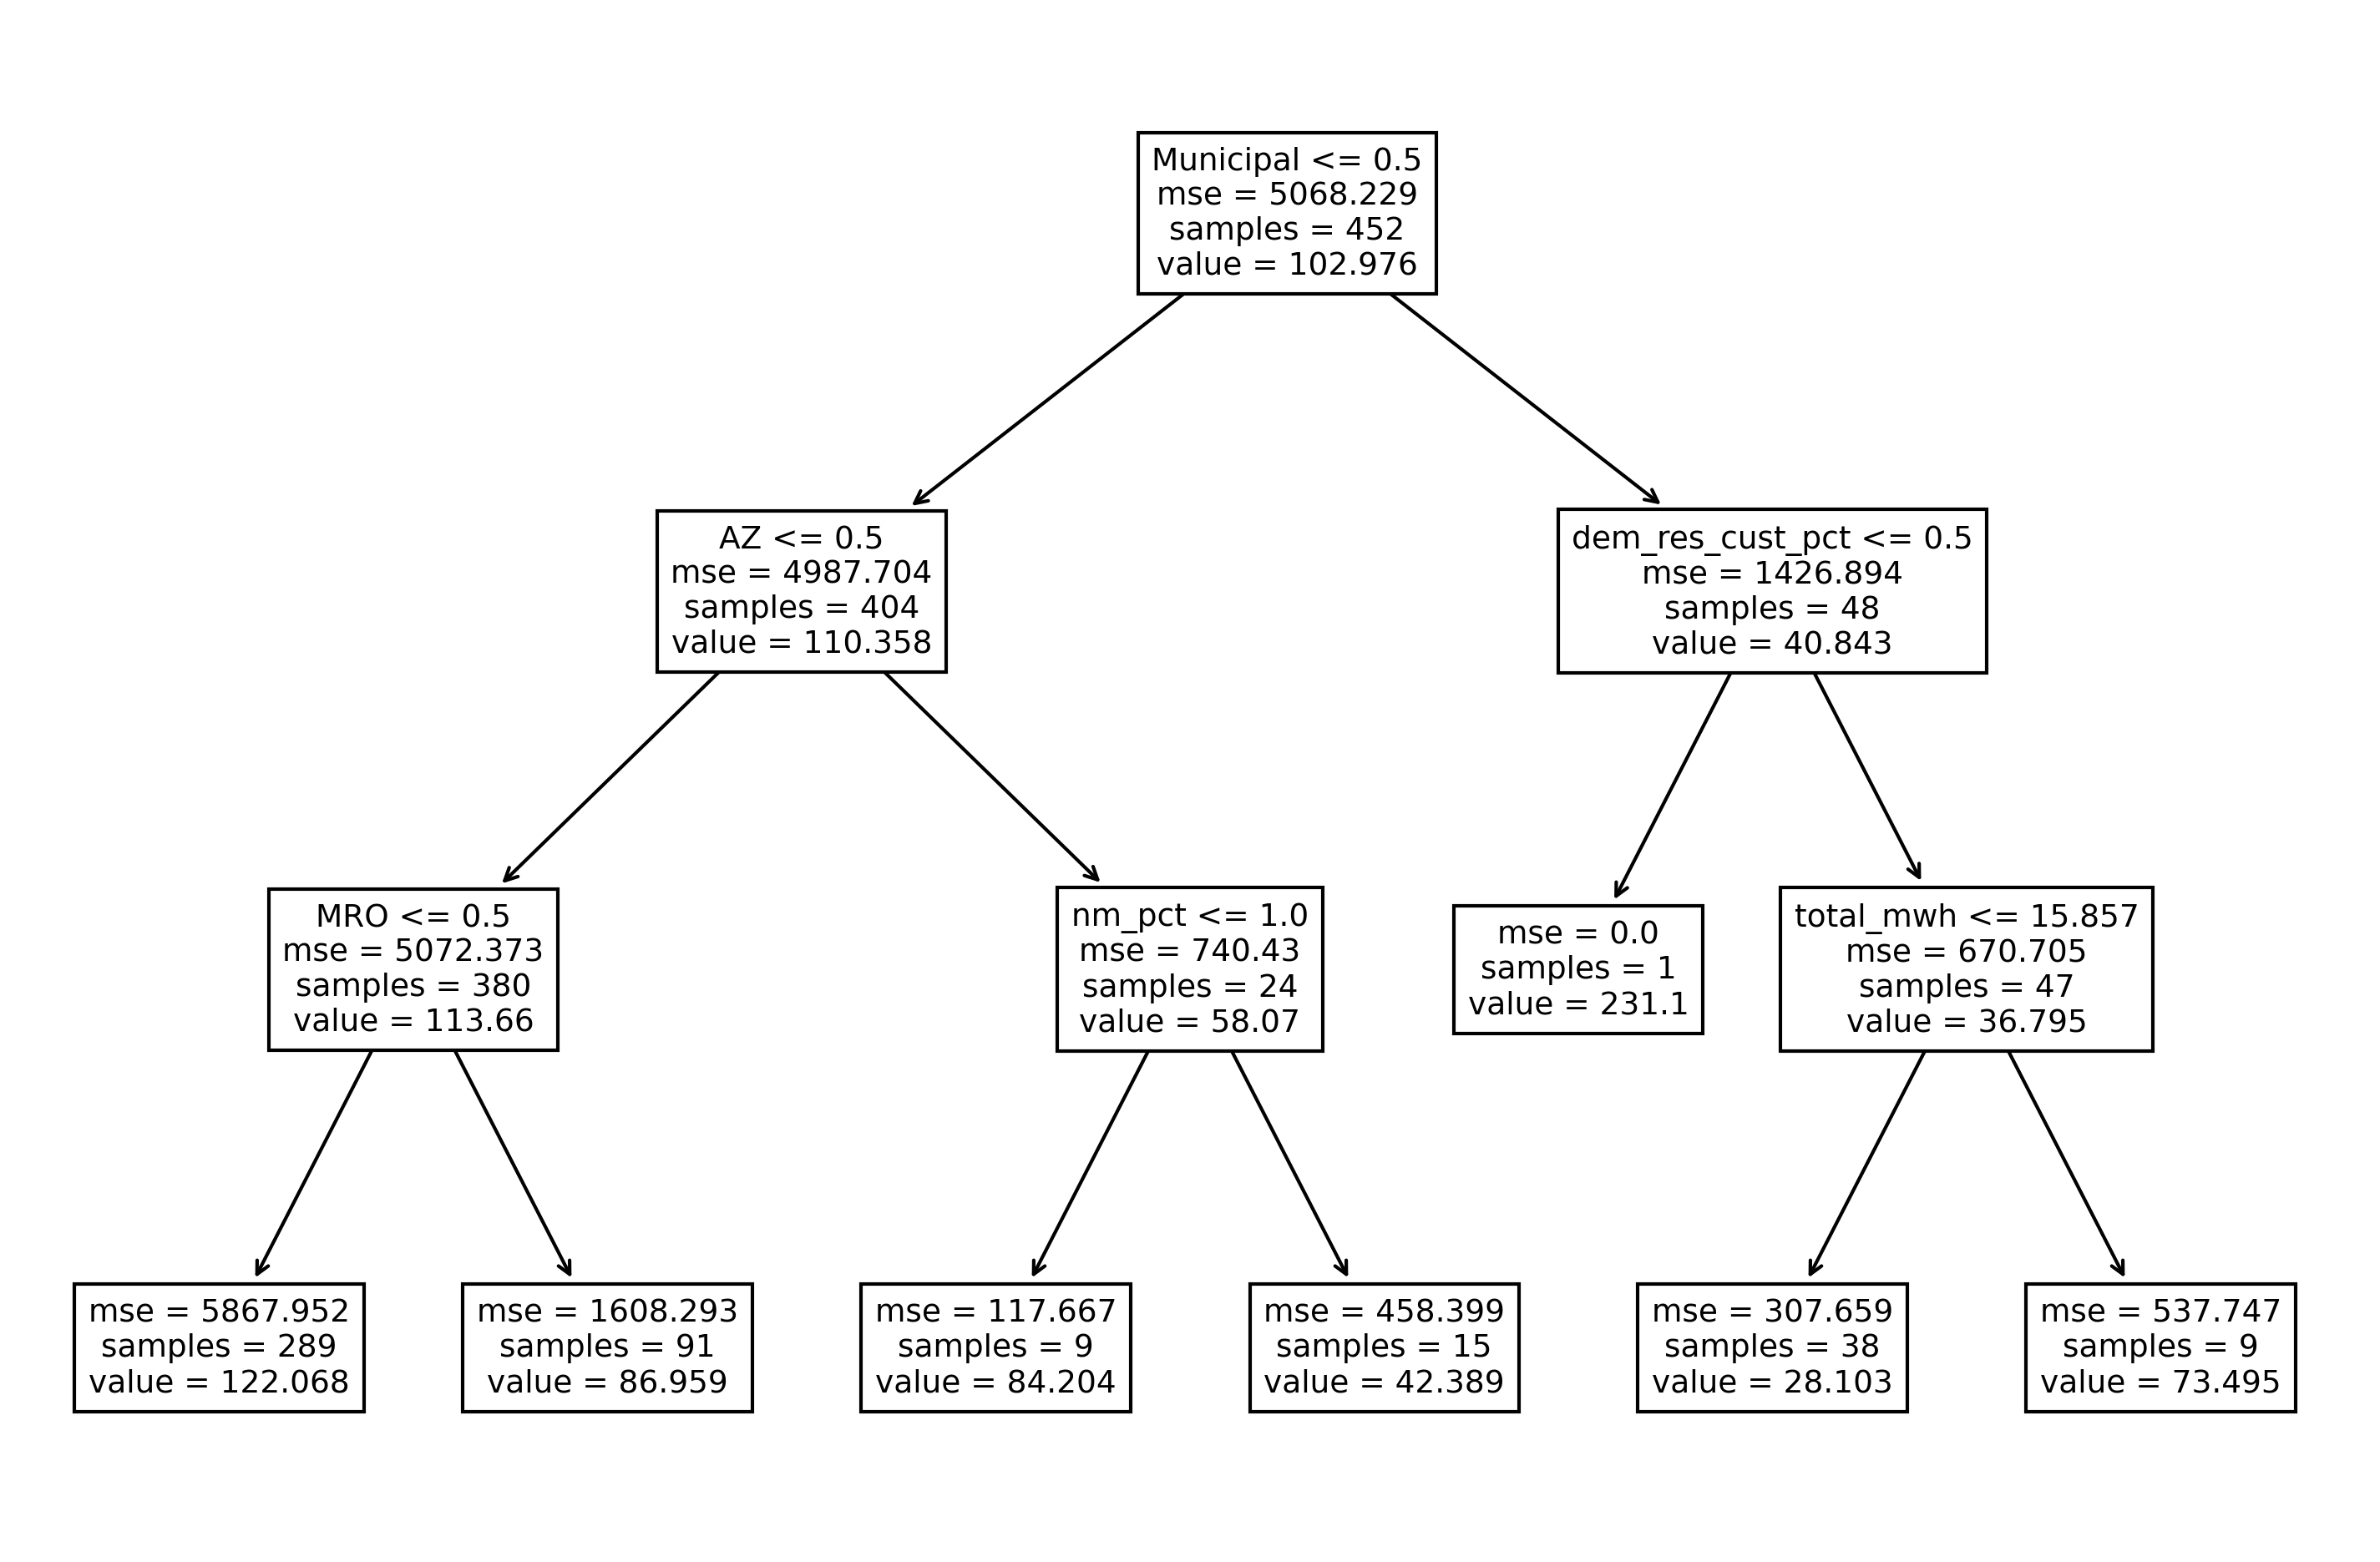

In [93]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X_log,train_y_log) # Fit the model

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=9)

### Bagging

In [94]:
bag_scores = cross_validate(Bag(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

### Random Forest

In [95]:
# takes longer, because 1000 models 
rf_scores = cross_validate(RF(),train_X_log,train_y_log, cv = fold_generator, scoring =use_metrics)

In [96]:
RF().get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

## Compare models

In [97]:
# Collect all the metrics we care about as a dictionary 
# name them by which method we used
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,1.596302e+15
1,lm,5.036415e+27
2,lm,6.889379e+29
3,lm,1.101090e+28
4,lm,9.781563e+26
5,knn,3.288761e+03
6,knn,3.207259e+03
7,knn,6.305701e+03
8,knn,5.980122e+03
9,knn,2.521216e+03


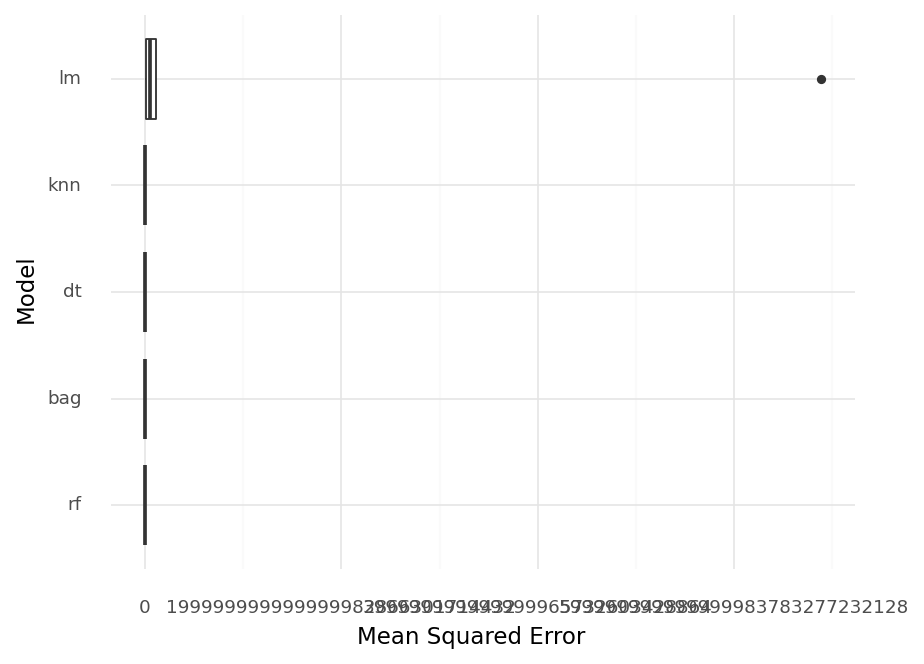

<ggplot: (8778803133097)>

In [98]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

# Hyperparameter tuning

In [114]:
knn_tune_params = {'n_neighbors':[1,2,3,5]}

In [115]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [116]:
tune_knn.fit(train_X_log,train_y_log)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': [1, 2, 3, 5]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [117]:
tune_knn.best_params_

{'n_neighbors': 2}

In [113]:
tune_knn.best_score_

-4211.2339560125765

In [125]:
train_X_log

,total_mwh,voltage,nm_pct,ee_pct,dem_res_cust_pct,HI,MRO,NPCC,RFC,SERC,...,NV,NY,OH,OK,PA,SC,SD,TX,VA,WI
555,18.098846,0,0,1.071977,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274,13.940842,1,2,0.334069,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
509,14.963857,0,1,0.066084,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,17.450303,2,0,0.773495,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0,11.801070,0,2,0.611183,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,12.691827,1,2,0.654128,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,15.933957,2,1,0.191452,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
247,15.780175,2,0,1.244674,2,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
304,14.650875,2,0,0.002815,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [126]:
rf_params = {'n_estimators':[1000,1250], 'max_depth': [5,10,20], 'max_features': [5,10,25]} 

tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4, 
                        verbose = 10)

In [127]:
tune_rf.fit(train_X_log,train_y_log)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   24.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   41.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [128]:
tune_rf.best_params_

{'max_depth': 20, 'max_features': 5, 'n_estimators': 1000}

In [129]:
tune_rf.best_score_

-2908.1353939402356

## ML pipeline

In [119]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(),  make_column_selector(dtype_exclude=None))])

In [120]:
# initialize our pipeline 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [130]:
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param, use double underscore to separate model from its parameter__
    {'model' : [KNN(n_neighbors=2)]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF(n_estimators = 1000, max_features = 5)],
    'model__max_depth':[20,25]}
]

In [131]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4,
                      verbose = 10)

In [133]:
search.fit(train_X_log,train_y_log)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0697s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:   10.7s remaining:    1.2s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   13.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_transfo

In [135]:
search.best_score_ # Mean out-of-sample (CV) error

-2939.0477644927983

In [136]:
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=25, max_features=5, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 25}

In [137]:
pred_y_log = search.predict(test_X_log)

In [138]:
m.mean_squared_error(test_y_log,pred_y_log)


4899.093398227265

In [139]:
m.r2_score(test_y_log,pred_y_log)


0.445976657998154

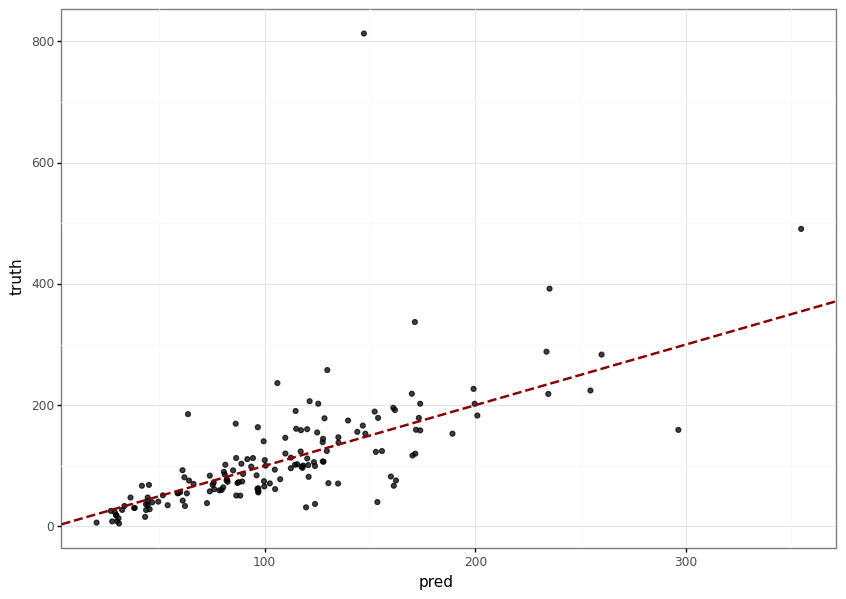

<ggplot: (8778782802501)>

In [140]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y_log,truth=test_y_log)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)